In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import chime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SequentialFeatureSelector
from statistics import mean, stdev
from tqdm.notebook import tqdm_notebook

In [3]:
%load_ext chime

# Model selection for the reservation data set
Preparing for Kaggle competion - the Playground Series - Season 3, Episode 7

https://www.kaggle.com/competitions/playground-series-s3e7
## Individual classifiers

### Note
I use the mean_test_score of cross validation in this notebook to compare model performance with different hyperparameters and see if the difference is big enough to continue optimization

# Data preparation

In [4]:
train = pd.read_csv('./data/train__dataset.csv'); train

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18132,1,0,0,2,0,0,0,103,2018,4,19,0,0,0,0,115.00,0,1
18133,2,0,0,3,0,0,0,129,2018,8,10,1,0,0,0,88.01,1,0
18134,2,0,0,1,0,0,0,90,2018,7,13,1,0,0,0,105.30,0,1
18135,2,0,0,3,0,0,0,18,2018,11,10,1,1,0,1,123.33,1,0


The dataset is small so I will not split a validation set, rather will base parameter selection on cross-validation results.

In [5]:
X_train = train.drop(columns='booking_status')
y_train = train.booking_status

In [6]:
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_train

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
0,0.296940,-0.262944,0.216265,1.255698,-0.506205,-0.180783,-0.435754,0.376664,-2.139435,1.484357,1.406570,0.300026,-0.160413,-0.060638,-0.088329,0.206385,1.754593
1,0.296940,2.182701,-0.928626,-0.146506,-0.506205,-0.180783,-0.435754,-0.789492,0.467413,-1.115651,-0.189318,0.300026,-0.160413,-0.060638,-0.088329,1.170495,-0.783738
2,-1.641023,-0.262944,0.216265,1.956800,-0.506205,-0.180783,-0.435754,3.043812,0.467413,0.834355,-1.329238,-1.248072,-0.160413,-0.060638,-0.088329,-0.191944,-0.783738
3,-1.641023,-0.262944,1.361156,1.255698,-0.506205,-0.180783,-0.435754,-0.189095,0.467413,-0.465649,-0.417302,-1.248072,-0.160413,-0.060638,-0.088329,0.465737,-0.783738
4,0.296940,-0.262944,-0.928626,1.255698,1.083310,-0.180783,-0.435754,-0.858769,0.467413,-2.090654,0.494634,0.300026,-0.160413,-0.060638,-0.088329,-0.957876,0.485428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18132,-1.641023,-0.262944,-0.928626,-0.146506,-0.506205,-0.180783,-0.435754,0.203472,0.467413,-1.115651,0.380642,-1.248072,-0.160413,-0.060638,-0.088329,0.324785,-0.783738
18133,0.296940,-0.262944,-0.928626,0.554596,-0.506205,-0.180783,-0.435754,0.503671,0.467413,0.184353,-0.645286,0.300026,-0.160413,-0.060638,-0.088329,-0.436073,0.485428
18134,0.296940,-0.262944,-0.928626,-0.847608,-0.506205,-0.180783,-0.435754,0.053373,0.467413,-0.140648,-0.303310,0.300026,-0.160413,-0.060638,-0.088329,0.051338,-0.783738
18135,0.296940,-0.262944,-0.928626,0.554596,-0.506205,-0.180783,-0.435754,-0.777946,0.467413,1.159356,-0.645286,0.300026,6.233902,-0.060638,0.495072,0.559610,0.485428


# Model selection

## Logistic regression

In [9]:
from sklearn.linear_model import LogisticRegression

In [27]:
estimator = LogisticRegression(class_weight='balanced',
                              random_state=8,
                              solver='liblinear')

In [28]:
params = {
    'C': [0.1, 1, 10],
    'max_iter': [50, 100, 500],
    'penalty': ['l1', 'l2']
}

In [29]:
logreg = GridSearchCV(estimator=estimator,
                     param_grid=params,
                     scoring='roc_auc',
                     cv = 5,
                     n_jobs=-1)

In [30]:
%%time
%%chime
logreg.fit(X_train, y_train)

CPU times: user 257 ms, sys: 69 ms, total: 326 ms
Wall time: 4.06 s


In [31]:
logreg.best_params_

{'C': 0.1, 'max_iter': 50, 'penalty': 'l2'}

In [32]:
logreg.best_score_

0.8497787776263923

In [38]:
results = pd.DataFrame(logreg.cv_results_).iloc[:, 4:]
results

,param_C,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.1,50,l1,"{'C': 0.1, 'max_iter': 50, 'penalty': 'l1'}",0.851912,0.854501,0.848767,0.847608,0.845888,0.849735,0.003089,16
1,0.1,50,l2,"{'C': 0.1, 'max_iter': 50, 'penalty': 'l2'}",0.851833,0.854397,0.848957,0.847637,0.846071,0.849779,0.002985,1
2,0.1,100,l1,"{'C': 0.1, 'max_iter': 100, 'penalty': 'l1'}",0.851912,0.854501,0.848767,0.847608,0.845888,0.849735,0.003089,16
3,0.1,100,l2,"{'C': 0.1, 'max_iter': 100, 'penalty': 'l2'}",0.851833,0.854397,0.848957,0.847637,0.846071,0.849779,0.002985,1
4,0.1,500,l1,"{'C': 0.1, 'max_iter': 500, 'penalty': 'l1'}",0.851912,0.854501,0.848767,0.847608,0.845888,0.849735,0.003089,16
5,0.1,500,l2,"{'C': 0.1, 'max_iter': 500, 'penalty': 'l2'}",0.851833,0.854397,0.848957,0.847637,0.846071,0.849779,0.002985,1
6,1,50,l1,"{'C': 1, 'max_iter': 50, 'penalty': 'l1'}",0.851846,0.854380,0.848986,0.847659,0.845989,0.849772,0.002998,10
7,1,50,l2,"{'C': 1, 'max_iter': 50, 'penalty': 'l2'}",0.851827,0.854379,0.849009,0.847655,0.846014,0.849777,0.002988,4
8,1,100,l1,"{'C': 1, 'max_iter': 100, 'penalty': 'l1'}",0.851846,0.854380,0.848986,0.847659,0.845989,0.849772,0.002998,10
9,1,100,l2,"{'C': 1, 'max_iter': 100, 'penalty': 'l2'}",0.851827,0.854379,0.849009,0.847655,0.846014,0.849777,0.002988,4


In [39]:
results.mean_test_score.describe()

count    18.000000
mean      0.849768
std       0.000015
min       0.849735
25%       0.849770
50%       0.849772
75%       0.849777
max       0.849779
Name: mean_test_score, dtype: float64

### Conclusion
Results do not depend much on the hyperparameters

## Decision trees

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
estimator = DecisionTreeClassifier(random_state=8, class_weight='balanced')

params = {
    'max_depth': [10, 100, 1000],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', None]
}

params = {
    'max_depth': [5, 10],
    'min_samples_split': [8, 10, 25, 50, 100],
    'max_features': ['sqrt', None]
}

In [33]:
params = {
    'max_depth': [7, 10, 20, 50],
    'min_samples_split': [20, 25, 30],
    'max_features': ['sqrt', None]
}

In [34]:
model = GridSearchCV(estimator=estimator,
                     param_grid=params,
                     scoring='roc_auc',
                     cv = 5,
                     n_jobs=-1)

In [35]:
%%time
%%chime
model.fit(X_train, y_train)

CPU times: user 214 ms, sys: 43.7 ms, total: 258 ms
Wall time: 2.4 s


In [36]:
model.best_params_

{'max_depth': 10, 'max_features': None, 'min_samples_split': 25}

In [37]:
model.best_score_

0.9249940025813819

In [38]:
results = pd.DataFrame(model.cv_results_).iloc[:, 4:]
results

,param_max_depth,param_max_features,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,7,sqrt,20,"{'max_depth': 7, 'max_features': 'sqrt', 'min_...",0.697530,0.812984,0.846437,0.779052,0.793234,0.785847,0.049615,22
1,7,sqrt,25,"{'max_depth': 7, 'max_features': 'sqrt', 'min_...",0.697530,0.813057,0.781805,0.793220,0.821856,0.781494,0.044301,23
2,7,sqrt,30,"{'max_depth': 7, 'max_features': 'sqrt', 'min_...",0.697530,0.813057,0.781805,0.793220,0.821856,0.781494,0.044301,23
3,7,None,20,"{'max_depth': 7, 'max_features': None, 'min_sa...",0.910442,0.909408,0.910562,0.904322,0.910242,0.908995,0.002371,9
4,7,None,25,"{'max_depth': 7, 'max_features': None, 'min_sa...",0.910442,0.910334,0.911228,0.904322,0.910688,0.909403,0.002559,7
5,7,None,30,"{'max_depth': 7, 'max_features': None, 'min_sa...",0.910486,0.910510,0.911228,0.904336,0.910690,0.909450,0.002571,6
6,10,sqrt,20,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.863447,0.899890,0.823231,0.854977,0.862429,0.860795,0.024425,20
7,10,sqrt,25,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.849599,0.846836,0.873917,0.877748,0.833057,0.856231,0.017000,21
8,10,sqrt,30,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.854673,0.873682,0.871655,0.868108,0.875142,0.868652,0.007378,19
9,10,None,20,"{'max_depth': 10, 'max_features': None, 'min_s...",0.922675,0.927561,0.923675,0.920584,0.926501,0.924199,0.002541,3


In [39]:
results.mean_test_score.describe()

count    24.000000
mean      0.885963
std       0.043462
min       0.781494
25%       0.886168
50%       0.901113
75%       0.909415
max       0.924994
Name: mean_test_score, dtype: float64

## Random forest

In [71]:
from sklearn.ensemble import RandomForestClassifier

In [88]:
estimator = RandomForestClassifier(n_jobs=-1, random_state=8, bootstrap=True)

params = {
    'n_estimators': [10, 100, 500],
    'max_depth': [10, 50, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', None],
    'max_samples': [0.3, 0.5, 0.7, 1.0]
}

In [89]:
params = {
    'n_estimators': [300, 500, 750, 1000],
    'max_depth': [30, 50, 100],
    'min_samples_split': [2, 3],
    'max_features': ['sqrt', None],
    'max_samples': [0.8, 1.0]
}

In [90]:
model = GridSearchCV(estimator=estimator,
                     param_grid=params,
                     scoring='roc_auc',
                     cv = 5,
                    verbose = 3)

In [91]:
%%time
%%chime
model.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END max_depth=30, max_features=sqrt, max_samples=0.8, min_samples_split=2, n_estimators=300;, score=0.947 total time=   2.0s
[CV 2/5] END max_depth=30, max_features=sqrt, max_samples=0.8, min_samples_split=2, n_estimators=300;, score=0.952 total time=   1.3s
[CV 3/5] END max_depth=30, max_features=sqrt, max_samples=0.8, min_samples_split=2, n_estimators=300;, score=0.946 total time=   1.2s
[CV 4/5] END max_depth=30, max_features=sqrt, max_samples=0.8, min_samples_split=2, n_estimators=300;, score=0.950 total time=   1.2s
[CV 5/5] END max_depth=30, max_features=sqrt, max_samples=0.8, min_samples_split=2, n_estimators=300;, score=0.948 total time=   1.3s
[CV 1/5] END max_depth=30, max_features=sqrt, max_samples=0.8, min_samples_split=2, n_estimators=500;, score=0.947 total time=   2.1s
[CV 2/5] END max_depth=30, max_features=sqrt, max_samples=0.8, min_samples_split=2, n_estimators=500;, score=0.953 total time=   2.0s


[CV 2/5] END max_depth=30, max_features=sqrt, max_samples=1.0, min_samples_split=3, n_estimators=300;, score=0.953 total time=   1.4s
[CV 3/5] END max_depth=30, max_features=sqrt, max_samples=1.0, min_samples_split=3, n_estimators=300;, score=0.947 total time=   1.4s
[CV 4/5] END max_depth=30, max_features=sqrt, max_samples=1.0, min_samples_split=3, n_estimators=300;, score=0.950 total time=   1.3s
[CV 5/5] END max_depth=30, max_features=sqrt, max_samples=1.0, min_samples_split=3, n_estimators=300;, score=0.948 total time=   1.3s
[CV 1/5] END max_depth=30, max_features=sqrt, max_samples=1.0, min_samples_split=3, n_estimators=500;, score=0.947 total time=   2.2s
[CV 2/5] END max_depth=30, max_features=sqrt, max_samples=1.0, min_samples_split=3, n_estimators=500;, score=0.954 total time=   2.2s
[CV 3/5] END max_depth=30, max_features=sqrt, max_samples=1.0, min_samples_split=3, n_estimators=500;, score=0.947 total time=   2.1s
[CV 4/5] END max_depth=30, max_features=sqrt, max_samples=1.0,

[CV 4/5] END max_depth=30, max_features=None, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=0.949 total time=   2.7s
[CV 5/5] END max_depth=30, max_features=None, max_samples=1.0, min_samples_split=2, n_estimators=300;, score=0.946 total time=   2.7s
[CV 1/5] END max_depth=30, max_features=None, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=0.946 total time=   4.5s
[CV 2/5] END max_depth=30, max_features=None, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=0.951 total time=   4.6s
[CV 3/5] END max_depth=30, max_features=None, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=0.945 total time=   4.9s
[CV 4/5] END max_depth=30, max_features=None, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=0.949 total time=   4.4s
[CV 5/5] END max_depth=30, max_features=None, max_samples=1.0, min_samples_split=2, n_estimators=500;, score=0.946 total time=   4.3s
[CV 1/5] END max_depth=30, max_features=None, max_samples=1.0,

[CV 1/5] END max_depth=50, max_features=sqrt, max_samples=0.8, min_samples_split=3, n_estimators=500;, score=0.947 total time=   2.0s
[CV 2/5] END max_depth=50, max_features=sqrt, max_samples=0.8, min_samples_split=3, n_estimators=500;, score=0.953 total time=   2.0s
[CV 3/5] END max_depth=50, max_features=sqrt, max_samples=0.8, min_samples_split=3, n_estimators=500;, score=0.946 total time=   2.0s
[CV 4/5] END max_depth=50, max_features=sqrt, max_samples=0.8, min_samples_split=3, n_estimators=500;, score=0.950 total time=   2.0s
[CV 5/5] END max_depth=50, max_features=sqrt, max_samples=0.8, min_samples_split=3, n_estimators=500;, score=0.948 total time=   1.9s
[CV 1/5] END max_depth=50, max_features=sqrt, max_samples=0.8, min_samples_split=3, n_estimators=750;, score=0.947 total time=   2.8s
[CV 2/5] END max_depth=50, max_features=sqrt, max_samples=0.8, min_samples_split=3, n_estimators=750;, score=0.953 total time=   2.8s
[CV 3/5] END max_depth=50, max_features=sqrt, max_samples=0.8,

[CV 3/5] END max_depth=50, max_features=None, max_samples=0.8, min_samples_split=2, n_estimators=500;, score=0.946 total time=   3.9s
[CV 4/5] END max_depth=50, max_features=None, max_samples=0.8, min_samples_split=2, n_estimators=500;, score=0.949 total time=   3.9s
[CV 5/5] END max_depth=50, max_features=None, max_samples=0.8, min_samples_split=2, n_estimators=500;, score=0.946 total time=   3.9s
[CV 1/5] END max_depth=50, max_features=None, max_samples=0.8, min_samples_split=2, n_estimators=750;, score=0.946 total time=   5.8s
[CV 2/5] END max_depth=50, max_features=None, max_samples=0.8, min_samples_split=2, n_estimators=750;, score=0.951 total time=   5.7s
[CV 3/5] END max_depth=50, max_features=None, max_samples=0.8, min_samples_split=2, n_estimators=750;, score=0.946 total time=   5.8s
[CV 4/5] END max_depth=50, max_features=None, max_samples=0.8, min_samples_split=2, n_estimators=750;, score=0.949 total time=   5.8s
[CV 5/5] END max_depth=50, max_features=None, max_samples=0.8,

[CV 5/5] END max_depth=50, max_features=None, max_samples=1.0, min_samples_split=3, n_estimators=500;, score=0.946 total time=   4.2s
[CV 1/5] END max_depth=50, max_features=None, max_samples=1.0, min_samples_split=3, n_estimators=750;, score=0.946 total time=   6.4s
[CV 2/5] END max_depth=50, max_features=None, max_samples=1.0, min_samples_split=3, n_estimators=750;, score=0.951 total time=   6.4s
[CV 3/5] END max_depth=50, max_features=None, max_samples=1.0, min_samples_split=3, n_estimators=750;, score=0.945 total time=   6.3s
[CV 4/5] END max_depth=50, max_features=None, max_samples=1.0, min_samples_split=3, n_estimators=750;, score=0.949 total time=   6.4s
[CV 5/5] END max_depth=50, max_features=None, max_samples=1.0, min_samples_split=3, n_estimators=750;, score=0.946 total time=   6.3s
[CV 1/5] END max_depth=50, max_features=None, max_samples=1.0, min_samples_split=3, n_estimators=1000;, score=0.946 total time=   8.5s
[CV 2/5] END max_depth=50, max_features=None, max_samples=1.0

[CV 1/5] END max_depth=100, max_features=sqrt, max_samples=1.0, min_samples_split=2, n_estimators=750;, score=0.947 total time=   3.1s
[CV 2/5] END max_depth=100, max_features=sqrt, max_samples=1.0, min_samples_split=2, n_estimators=750;, score=0.954 total time=   3.1s
[CV 3/5] END max_depth=100, max_features=sqrt, max_samples=1.0, min_samples_split=2, n_estimators=750;, score=0.947 total time=   3.1s
[CV 4/5] END max_depth=100, max_features=sqrt, max_samples=1.0, min_samples_split=2, n_estimators=750;, score=0.951 total time=   3.1s
[CV 5/5] END max_depth=100, max_features=sqrt, max_samples=1.0, min_samples_split=2, n_estimators=750;, score=0.948 total time=   3.1s
[CV 1/5] END max_depth=100, max_features=sqrt, max_samples=1.0, min_samples_split=2, n_estimators=1000;, score=0.947 total time=   4.1s
[CV 2/5] END max_depth=100, max_features=sqrt, max_samples=1.0, min_samples_split=2, n_estimators=1000;, score=0.954 total time=   4.1s
[CV 3/5] END max_depth=100, max_features=sqrt, max_sa

[CV 2/5] END max_depth=100, max_features=None, max_samples=0.8, min_samples_split=3, n_estimators=750;, score=0.951 total time=   5.7s
[CV 3/5] END max_depth=100, max_features=None, max_samples=0.8, min_samples_split=3, n_estimators=750;, score=0.946 total time=   5.6s
[CV 4/5] END max_depth=100, max_features=None, max_samples=0.8, min_samples_split=3, n_estimators=750;, score=0.949 total time=   5.7s
[CV 5/5] END max_depth=100, max_features=None, max_samples=0.8, min_samples_split=3, n_estimators=750;, score=0.946 total time=   5.6s
[CV 1/5] END max_depth=100, max_features=None, max_samples=0.8, min_samples_split=3, n_estimators=1000;, score=0.946 total time=   7.5s
[CV 2/5] END max_depth=100, max_features=None, max_samples=0.8, min_samples_split=3, n_estimators=1000;, score=0.951 total time=   7.6s
[CV 3/5] END max_depth=100, max_features=None, max_samples=0.8, min_samples_split=3, n_estimators=1000;, score=0.946 total time=   8.0s
[CV 4/5] END max_depth=100, max_features=None, max_s

In [92]:
model.best_params_

{'max_depth': 100,
 'max_features': 'sqrt',
 'max_samples': 1.0,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [93]:
model.best_score_

0.9495807215415704

In [94]:
results = pd.DataFrame(model.cv_results_).iloc[:, 4:]
results

,param_max_depth,param_max_features,param_max_samples,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,30,sqrt,0.8,2,300,"{'max_depth': 30, 'max_features': 'sqrt', 'max...",0.946818,0.951681,0.946346,0.950024,0.947800,0.948534,0.002019,46
1,30,sqrt,0.8,2,500,"{'max_depth': 30, 'max_features': 'sqrt', 'max...",0.947070,0.952661,0.946259,0.950131,0.947615,0.948747,0.002346,40
2,30,sqrt,0.8,2,750,"{'max_depth': 30, 'max_features': 'sqrt', 'max...",0.947281,0.952638,0.946240,0.950641,0.947860,0.948932,0.002357,34
3,30,sqrt,0.8,2,1000,"{'max_depth': 30, 'max_features': 'sqrt', 'max...",0.947382,0.952887,0.946056,0.950733,0.947998,0.949011,0.002466,26
4,30,sqrt,0.8,3,300,"{'max_depth': 30, 'max_features': 'sqrt', 'max...",0.946651,0.952311,0.946027,0.950465,0.947702,0.948631,0.002386,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,100,None,1.0,2,1000,"{'max_depth': 100, 'max_features': None, 'max_...",0.945764,0.951160,0.945831,0.949843,0.946225,0.947765,0.002278,50
92,100,None,1.0,3,300,"{'max_depth': 100, 'max_features': None, 'max_...",0.945107,0.951427,0.944882,0.948675,0.945404,0.947099,0.002568,88
93,100,None,1.0,3,500,"{'max_depth': 100, 'max_features': None, 'max_...",0.945540,0.951017,0.944848,0.948965,0.945737,0.947221,0.002371,86
94,100,None,1.0,3,750,"{'max_depth': 100, 'max_features': None, 'max_...",0.945798,0.951054,0.944955,0.949386,0.945939,0.947426,0.002365,74


In [95]:
results.mean_test_score.describe()

count    96.000000
mean      0.948222
std       0.000872
min       0.946751
25%       0.947441
50%       0.948137
75%       0.949020
max       0.949581
Name: mean_test_score, dtype: float64

## XGBoost

In [97]:
from xgboost import XGBClassifier

In [115]:
estimator = XGBClassifier(random_state=8,
                         max_leaves=0,
                         n_jobs=-1)

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

params = {
    'n_estimators': [150, 200, 300, 400],
    'max_depth': [5, 6, 8, 10],
    'learning_rate': [0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.05],
    'reg_lambda': [0, 0.1, 0.2]
}

In [116]:
params = {
    'n_estimators': [120, 150, 170],
    'max_depth': [8],
    'learning_rate': [0.2],
    'reg_alpha': [0.05],
    'reg_lambda': [0.2, 0.3]
}

In [117]:
model = GridSearchCV(estimator=estimator,
                     param_grid=params,
                     scoring='roc_auc',
                     cv = 5,
                    verbose = 3)

In [118]:
%%time
%%chime
model.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END learning_rate=0.2, max_depth=8, n_estimators=120, reg_alpha=0.05, reg_lambda=0.2;, score=0.948 total time=   0.8s
[CV 2/5] END learning_rate=0.2, max_depth=8, n_estimators=120, reg_alpha=0.05, reg_lambda=0.2;, score=0.952 total time=   1.0s
[CV 3/5] END learning_rate=0.2, max_depth=8, n_estimators=120, reg_alpha=0.05, reg_lambda=0.2;, score=0.949 total time=   1.1s
[CV 4/5] END learning_rate=0.2, max_depth=8, n_estimators=120, reg_alpha=0.05, reg_lambda=0.2;, score=0.950 total time=   0.8s
[CV 5/5] END learning_rate=0.2, max_depth=8, n_estimators=120, reg_alpha=0.05, reg_lambda=0.2;, score=0.950 total time=   0.8s
[CV 1/5] END learning_rate=0.2, max_depth=8, n_estimators=120, reg_alpha=0.05, reg_lambda=0.3;, score=0.946 total time=   0.7s
[CV 2/5] END learning_rate=0.2, max_depth=8, n_estimators=120, reg_alpha=0.05, reg_lambda=0.3;, score=0.952 total time=   0.7s
[CV 3/5] END learning_rate=0.2, max_depth=8, n_esti

In [119]:
model.best_params_

{'learning_rate': 0.2,
 'max_depth': 8,
 'n_estimators': 120,
 'reg_alpha': 0.05,
 'reg_lambda': 0.3}

In [120]:
model.best_score_

0.9498993319202901

In [121]:
results = pd.DataFrame(model.cv_results_).iloc[:, 4:]
results

,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.2,8,120,0.05,0.2,"{'learning_rate': 0.2, 'max_depth': 8, 'n_esti...",0.948135,0.952207,0.949027,0.949797,0.949520,0.949737,0.001358,4
1,0.2,8,120,0.05,0.3,"{'learning_rate': 0.2, 'max_depth': 8, 'n_esti...",0.945959,0.951927,0.950604,0.950116,0.950890,0.949899,0.002057,1
2,0.2,8,150,0.05,0.2,"{'learning_rate': 0.2, 'max_depth': 8, 'n_esti...",0.947707,0.951973,0.948980,0.950456,0.949456,0.949714,0.001434,5
3,0.2,8,150,0.05,0.3,"{'learning_rate': 0.2, 'max_depth': 8, 'n_esti...",0.946301,0.951785,0.949902,0.950429,0.950589,0.949801,0.001855,2
4,0.2,8,170,0.05,0.2,"{'learning_rate': 0.2, 'max_depth': 8, 'n_esti...",0.947436,0.951394,0.949170,0.950589,0.949194,0.949557,0.001358,6
5,0.2,8,170,0.05,0.3,"{'learning_rate': 0.2, 'max_depth': 8, 'n_esti...",0.946087,0.952100,0.949986,0.950609,0.950160,0.949788,0.001995,3


In [122]:
results.mean_test_score.describe()

count    6.000000
mean     0.949749
std      0.000114
min      0.949557
25%      0.949720
50%      0.949763
75%      0.949798
max      0.949899
Name: mean_test_score, dtype: float64

### XGBoost worked best so far but Random Forest is very close

# Feature selection

In [6]:
from xgboost import XGBClassifier

In [7]:
best_params = \
{'learning_rate': 0.2,
 'max_depth': 8,
 'n_estimators': 120,
 'reg_alpha': 0.05,
 'reg_lambda': 0.3}

Function to evaluate performance with a subset of features

In [18]:
def crossval(X, y, n_splits=5):
    '''
    Mean auc with cross-validation.
    '''
    kf = KFold(n_splits=n_splits)
    auc = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        model = XGBClassifier(random_state=8,
                              max_leaves=0,
                              n_jobs=-1,
                             **best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)[:, 1]
        auc += [roc_auc_score(y_test, y_pred)]
    return(mean(auc), stdev(auc))

In [19]:
best_params

{'learning_rate': 0.2,
 'max_depth': 8,
 'n_estimators': 120,
 'reg_alpha': 0.05,
 'reg_lambda': 0.3}

In [20]:
n_splits = 5

In [21]:
features = X_train.columns.to_list()
n_features = len(features)
selected_features = []

Table to accumulate the results of feature selection

In [22]:
results = pd.DataFrame({'n_features': list(range(n_features))})
results['features'] = results.apply(lambda _: [], axis=1)
results['auc'] = 0
results['std'] = 0
results.set_index('n_features', inplace=True)
results

,features,auc,std
n_features,,,
0,[],0,0
1,[],0,0
2,[],0,0
3,[],0,0
4,[],0,0
5,[],0,0
6,[],0,0
7,[],0,0
8,[],0,0


In [23]:
%%chime
for i in tqdm_notebook(range(n_features)):
    temp_results = {}
    temp_std = {}
    for feature in features:
        temp_features = selected_features + [feature]
        crossval_result = crossval(X_train.loc[:, temp_features], y_train, n_splits=5)
        temp_results[feature] = crossval_result[0]
        temp_std[feature] = crossval_result[1]
    feature_best_increment = max(temp_results, key=temp_results.get)
    selected_features += [feature_best_increment]
    features.remove(feature_best_increment)
    results.loc[i, 'features'] = feature_best_increment
    results.loc[i, 'auc'] = temp_results[feature_best_increment]
    results.loc[i, 'std'] = temp_std[feature_best_increment]



  0%|          | 0/17 [00:00<?, ?it/s]

In [24]:
results

,features,auc,std
n_features,,,
0,lead_time,0.769573,0.011029
1,avg_price_per_room,0.849855,0.008309
2,no_of_special_requests,0.902462,0.005257
3,market_segment_type,0.924324,0.003452
4,arrival_month,0.937968,0.001671
5,no_of_weekend_nights,0.942368,0.001057
6,required_car_parking_space,0.944773,0.001403
7,arrival_year,0.946473,0.000590
8,no_of_week_nights,0.947715,0.001897


In [25]:
results.auc.idxmax()

16

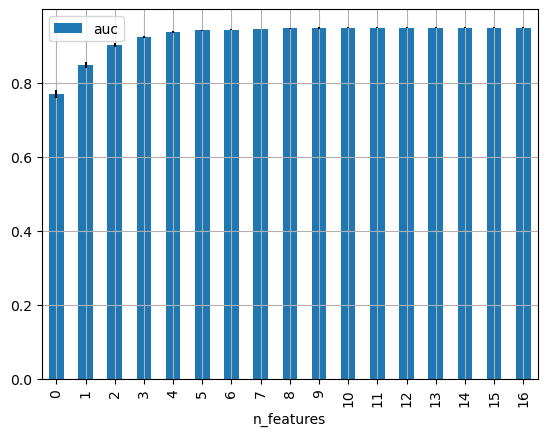

In [26]:
results.plot(y='auc',
              kind='bar',
              use_index=True,
              grid=True,
              yerr='std');


## Using predict instead of predict_proba because the contest requires labels

In [27]:
def crossval_label(X, y, n_splits=5):
    '''
    Mean auc with cross-validation.
    '''
    kf = KFold(n_splits=n_splits)
    auc = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        model = XGBClassifier(random_state=8,
                              max_leaves=0,
                              n_jobs=-1,
                             **best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        auc += [roc_auc_score(y_test, y_pred)]
    return(mean(auc), stdev(auc))

In [28]:
features = X_train.columns.to_list()
n_features = len(features)
selected_features = []

Table to accumulate the results of feature selection

In [29]:
results_label = pd.DataFrame({'n_features': list(range(n_features))})
results_label['features'] = results.apply(lambda _: [], axis=1)
results_label['auc'] = 0
results_label['std'] = 0
results_label.set_index('n_features', inplace=True)
results_label

,features,auc,std
n_features,,,
0,[],0,0
1,[],0,0
2,[],0,0
3,[],0,0
4,[],0,0
5,[],0,0
6,[],0,0
7,[],0,0
8,[],0,0


In [30]:
%%chime
for i in tqdm_notebook(range(n_features)):
    temp_results = {}
    temp_std = {}
    for feature in features:
        temp_features = selected_features + [feature]
        crossval_result = crossval_label(X_train.loc[:, temp_features], y_train, n_splits=5)
        temp_results[feature] = crossval_result[0]
        temp_std[feature] = crossval_result[1]
    feature_best_increment = max(temp_results, key=temp_results.get)
    selected_features += [feature_best_increment]
    features.remove(feature_best_increment)
    results_label.loc[i, 'features'] = feature_best_increment
    results_label.loc[i, 'auc'] = temp_results[feature_best_increment]
    results_label.loc[i, 'std'] = temp_std[feature_best_increment]



  0%|          | 0/17 [00:00<?, ?it/s]

In [34]:
results_label

,features,auc,std
n_features,,,
0,lead_time,0.683154,0.005205
1,avg_price_per_room,0.746255,0.010135
2,no_of_special_requests,0.810693,0.006076
3,market_segment_type,0.838324,0.005573
4,arrival_month,0.850243,0.003635
5,no_of_week_nights,0.856107,0.006269
6,required_car_parking_space,0.858141,0.003426
7,no_of_weekend_nights,0.861312,0.005789
8,arrival_year,0.864007,0.004523


In [35]:
results_label.auc.idxmax()

15

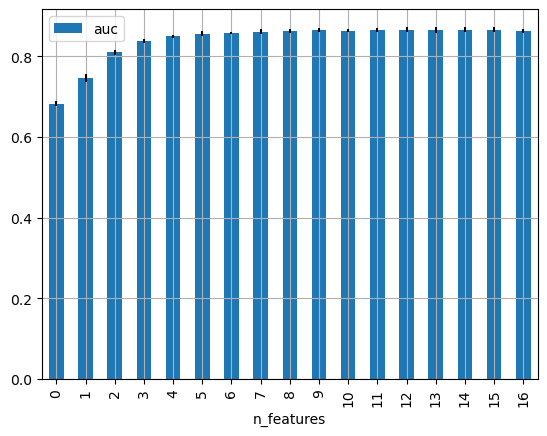

In [36]:
results_label.plot(y='auc',
              kind='bar',
              use_index=True,
              grid=True,
              yerr='std');


# PCA

In [56]:
from sklearn.decomposition import PCA

In [57]:
X_pca = PCA().fit_transform(X_train)
X_pca = pd.DataFrame(X_pca)
X_pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.472678,0.015315,-1.325823,2.232903,-1.573818,-0.764270,-1.422392,0.020199,-0.740464,0.194699,0.621727,0.670041,-0.082743,-0.063519,-0.062026,-0.123595,0.951454
1,-0.351063,1.374997,-0.009533,-1.382081,0.969945,0.970030,0.301204,0.224839,0.089849,0.457280,0.460318,0.340711,0.060208,-0.182565,1.887336,-0.288702,0.523615
2,-0.750788,-1.897995,1.557156,1.634622,-0.292195,1.840876,1.677140,-1.498150,-1.228667,-0.885487,0.229444,0.443787,0.499831,0.072938,-0.554177,-0.081868,0.634429
3,-0.270027,-0.750363,1.150913,-0.155202,-0.824990,1.397781,0.414956,-0.581281,0.999352,-0.043700,0.166422,0.937589,1.537697,-0.326688,-0.428963,-0.126210,0.184382
4,0.255983,-0.320663,0.926616,-1.388466,-0.121209,-0.735468,-0.580906,0.521422,0.347889,-0.225058,2.285901,0.411131,-0.975038,-0.225814,0.125706,0.024684,-0.374845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18132,0.152792,-0.993062,0.495032,-1.346539,0.845540,1.093635,-0.111391,-0.448919,-0.505962,0.431723,0.258439,1.081582,0.778195,-0.382035,-0.525469,-0.050710,0.432327
18133,-0.040559,-0.283684,0.241036,0.028813,-0.399386,-0.291213,0.881526,0.264337,-1.262159,-0.072013,0.494178,0.100370,-0.323654,0.126073,0.260586,0.036356,-0.083014
18134,0.204424,-0.376306,-0.056333,-0.925384,0.531503,0.002138,0.502368,0.349900,-0.749278,0.551650,-0.370207,-0.514594,0.095564,0.259972,0.470416,0.089746,0.142298
18135,3.390502,1.246958,-0.101968,1.357117,0.069859,-0.391082,0.865069,0.295609,-1.183588,-0.100519,0.562325,-1.414425,1.233866,-2.526355,0.081602,-4.010669,-0.720008


In [58]:
features = X_pca.columns.to_list()
n_features = len(features)
selected_features = []

Table to accumulate the results of feature selection. It does not include the features column as they are just numbers

In [59]:
results_pca = pd.DataFrame({'n_features': list(range(n_features))})
results_pca['auc'] = 0
results_pca['std'] = 0
results_pca.set_index('n_features', inplace=True)

In [60]:
%%chime
for i in tqdm_notebook(range(n_features)):
    temp_results = {}
    temp_std = {}
    for feature in features:
        temp_features = selected_features + [feature]
        crossval_result = crossval(X_train.iloc[:, temp_features], y_train, n_splits=5)
        temp_results[feature] = crossval_result[0]
        temp_std[feature] = crossval_result[1]
    feature_best_increment = max(temp_results, key=temp_results.get)
    selected_features += [feature_best_increment]
    features.remove(feature_best_increment)
    results_pca.loc[i, 'auc'] = temp_results[feature_best_increment]
    results_pca.loc[i, 'std'] = temp_std[feature_best_increment]



  0%|          | 0/17 [00:00<?, ?it/s]

In [61]:
results_pca

,auc,std
n_features,,
0,0.769573,0.011029
1,0.849855,0.008309
2,0.902462,0.005257
3,0.924324,0.003452
4,0.937968,0.001671
5,0.942368,0.001057
6,0.944773,0.001403
7,0.946473,0.000590
8,0.947715,0.001897


In [62]:
results_pca.auc.idxmax()

16

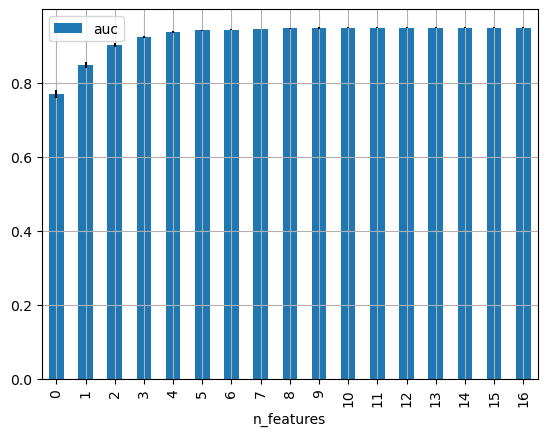

In [63]:
results_pca.plot(y='auc',
              kind='bar',
              use_index=True,
              grid=True,
              yerr='std');


# Conclusion so far
- Feature selection and engineering hold little promise.
- The competition accepts labels, not probabilities to calculate ROC-AUC

# Non-tree-based methods

## KNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
estimator = KNeighborsClassifier(algorithm='auto', metric='minkowski', n_jobs=-1)

params = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

params = {
    'n_neighbors': [8, 10, 15, 20, 25],
    'weights': ['distance'],
    'p': [1]
}

In [32]:
params = {
    'n_neighbors': [22, 25, 30, 40, 50],
    'weights': ['distance'],
    'p': [1]
}

In [33]:
model = GridSearchCV(estimator=estimator,
                     param_grid=params,
                     scoring='roc_auc',
                     cv = 5,
                    verbose=3)

In [34]:
%%time
%%chime
model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END n_neighbors=22, p=1, weights=distance;, score=0.928 total time=   1.1s
[CV 2/5] END n_neighbors=22, p=1, weights=distance;, score=0.933 total time=   1.0s
[CV 3/5] END n_neighbors=22, p=1, weights=distance;, score=0.924 total time=   1.0s
[CV 4/5] END n_neighbors=22, p=1, weights=distance;, score=0.930 total time=   1.0s
[CV 5/5] END n_neighbors=22, p=1, weights=distance;, score=0.927 total time=   1.1s
[CV 1/5] END n_neighbors=25, p=1, weights=distance;, score=0.929 total time=   1.1s
[CV 2/5] END n_neighbors=25, p=1, weights=distance;, score=0.934 total time=   1.0s
[CV 3/5] END n_neighbors=25, p=1, weights=distance;, score=0.924 total time=   1.0s
[CV 4/5] END n_neighbors=25, p=1, weights=distance;, score=0.931 total time=   1.0s
[CV 5/5] END n_neighbors=25, p=1, weights=distance;, score=0.927 total time=   1.0s
[CV 1/5] END n_neighbors=30, p=1, weights=distance;, score=0.929 total time=   1.0s
[CV 2/5] END n_n

In [35]:
model.best_params_

{'n_neighbors': 40, 'p': 1, 'weights': 'distance'}

In [36]:
model.best_score_

0.9294982428519282

In [37]:
pd.Series(model.cv_results_['mean_test_score']).describe()

count    5.000000
mean     0.929101
std      0.000390
min      0.928458
25%      0.929121
50%      0.929142
75%      0.929286
max      0.929498
dtype: float64

## Naive Bayes

In [99]:
from sklearn.naive_bayes import GaussianNB

In [100]:
estimator = GaussianNB()

In [101]:
params = {
    'var_smoothing': [1e-9]
}

In [102]:
model = GridSearchCV(estimator=estimator,
                     param_grid=params,
                     scoring='roc_auc',
                     cv = 5,
                    verbose=3)

In [103]:
%%time
%%chime
model.fit(X_train_nb, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...............var_smoothing=1e-09;, score=0.819 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-09;, score=0.807 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-09;, score=0.806 total time=   0.0s
[CV 4/5] END ...............var_smoothing=1e-09;, score=0.809 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-09;, score=0.809 total time=   0.0s
CPU times: user 94.1 ms, sys: 0 ns, total: 94.1 ms
Wall time: 93.9 ms


In [104]:
model.best_params_

{'var_smoothing': 1e-09}

In [105]:
model.best_score_

0.8100665347185225

In [106]:
pd.Series(model.cv_results_['mean_test_score']).describe()

count    1.000000
mean     0.810067
std           NaN
min      0.810067
25%      0.810067
50%      0.810067
75%      0.810067
max      0.810067
dtype: float64

## SVM

In [107]:
from sklearn.svm import SVC

In [108]:
estimator = SVC(degree=3, class_weight='balanced', random_state=8)

In [109]:
params = {
    'C': [0.1, 1, 10],
    'kernel': ['poly', 'rbf'],
    'gamma': ['scale', 'auto'],
    'coef0': [0.0, 1.0]
}

In [110]:
model = GridSearchCV(estimator=estimator,
                     param_grid=params,
                     scoring='roc_auc',
                     cv = 5,
                    verbose=3)

In [ ]:
%%time
%%chime
model.fit(X_train_nb, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.1, coef0=0.0, gamma=scale, kernel=poly;, score=0.781 total time=   9.2s
[CV 2/5] END C=0.1, coef0=0.0, gamma=scale, kernel=poly;, score=0.793 total time=   9.4s
[CV 3/5] END C=0.1, coef0=0.0, gamma=scale, kernel=poly;, score=0.781 total time=   9.2s
[CV 4/5] END C=0.1, coef0=0.0, gamma=scale, kernel=poly;, score=0.791 total time=   9.0s
[CV 5/5] END C=0.1, coef0=0.0, gamma=scale, kernel=poly;, score=0.783 total time=   9.0s
[CV 1/5] END C=0.1, coef0=0.0, gamma=scale, kernel=rbf;, score=0.780 total time=  13.5s
[CV 2/5] END C=0.1, coef0=0.0, gamma=scale, kernel=rbf;, score=0.789 total time=  13.2s
[CV 3/5] END C=0.1, coef0=0.0, gamma=scale, kernel=rbf;, score=0.772 total time=  13.2s
[CV 4/5] END C=0.1, coef0=0.0, gamma=scale, kernel=rbf;, score=0.788 total time=  13.5s
[CV 5/5] END C=0.1, coef0=0.0, gamma=scale, kernel=rbf;, score=0.776 total time=  13.1s


I interrupted execution as score was obviously low.

## AdaBoost

In [7]:
from sklearn.ensemble import AdaBoostClassifier

from sklearn.tree import DecisionTreeClassifier

params = {
    'n_estimators': [20, 50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'base_estimator__max_depth': [1, 5, 10],
    'base_estimator__min_samples_split': [2, 5, 10, 20],
    'base_estimator__max_features': ['sqrt', None]
}

params = {
    'n_estimators': [70, 100, 150],
    'learning_rate': [0.005, 0.01, 0.05],
    'base_estimator__max_depth': [7, 10, 15],
    'base_estimator__min_samples_split': [15, 20, 25, 30, 50],
    'base_estimator__max_features': ['sqrt', None]
}

In [41]:
params = {
    'n_estimators': [120, 150, 180],
    'learning_rate': [0.001, 0.005, 0.007],
    'base_estimator__max_depth': [7, 10, 15],
    'base_estimator__min_samples_split': [40, 50, 70],
    'base_estimator__max_features': ['sqrt', None]
}

In [42]:
model = GridSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=8),
                                                  random_state=8),
                     param_grid=params,
                     scoring='roc_auc',
                     cv = 5,
                     n_jobs=-1,
                    verbose=3)

In [43]:
%%time
%%chime
model.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=120;, score=0.929 total time=   1.6s
[CV 5/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=120;, score=0.933 total time=   1.7s
[CV 4/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=150;, score=0.933 total time=   2.1s
[CV 3/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=180;, score=0.928 total time=   2.4s
[CV 2/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.005, n_estimators=120;, score=0.938 total time=   1.7s
[CV 1/5

[CV 4/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=120;, score=0.932 total time=   1.7s
[CV 3/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=150;, score=0.928 total time=   2.1s
[CV 5/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=150;, score=0.933 total time=   2.0s
[CV 4/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=180;, score=0.934 total time=   2.4s
[CV 4/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.005, n_estimators=120;, score=0.938 total time=   1.8s
[CV 3/5] END base_estimator__max_depth=7, base_estimator__max_features

[CV 2/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=120;, score=0.931 total time=   1.7s
[CV 2/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=150;, score=0.931 total time=   2.2s
[CV 1/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=180;, score=0.930 total time=   2.5s
[CV 5/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=180;, score=0.934 total time=   2.4s
[CV 5/5] END base_estimator__max_depth=7, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.005, n_estimators=120;, score=0.937 total time=   1.8s
[CV 4/5] END base_estimator__max_depth=7, base_estimator__max_features

[CV 2/5] END base_estimator__max_depth=7, base_estimator__max_features=None, base_estimator__min_samples_split=40, learning_rate=0.007, n_estimators=180;, score=0.941 total time=   5.8s
[CV 1/5] END base_estimator__max_depth=7, base_estimator__max_features=None, base_estimator__min_samples_split=50, learning_rate=0.001, n_estimators=120;, score=0.925 total time=   3.8s
[CV 4/5] END base_estimator__max_depth=7, base_estimator__max_features=None, base_estimator__min_samples_split=50, learning_rate=0.001, n_estimators=120;, score=0.922 total time=   3.8s
[CV 3/5] END base_estimator__max_depth=7, base_estimator__max_features=None, base_estimator__min_samples_split=50, learning_rate=0.001, n_estimators=150;, score=0.927 total time=   4.8s
[CV 2/5] END base_estimator__max_depth=7, base_estimator__max_features=None, base_estimator__min_samples_split=50, learning_rate=0.001, n_estimators=180;, score=0.929 total time=   5.8s
[CV 1/5] END base_estimator__max_depth=7, base_estimator__max_features

[CV 2/5] END base_estimator__max_depth=7, base_estimator__max_features=None, base_estimator__min_samples_split=50, learning_rate=0.001, n_estimators=150;, score=0.928 total time=   4.7s
[CV 1/5] END base_estimator__max_depth=7, base_estimator__max_features=None, base_estimator__min_samples_split=50, learning_rate=0.001, n_estimators=180;, score=0.927 total time=   5.7s
[CV 5/5] END base_estimator__max_depth=7, base_estimator__max_features=None, base_estimator__min_samples_split=50, learning_rate=0.001, n_estimators=180;, score=0.923 total time=   5.7s
[CV 1/5] END base_estimator__max_depth=7, base_estimator__max_features=None, base_estimator__min_samples_split=50, learning_rate=0.005, n_estimators=150;, score=0.933 total time=   4.8s
[CV 5/5] END base_estimator__max_depth=7, base_estimator__max_features=None, base_estimator__min_samples_split=50, learning_rate=0.005, n_estimators=150;, score=0.939 total time=   4.8s
[CV 4/5] END base_estimator__max_depth=7, base_estimator__max_features

[CV 4/5] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_split=50, learning_rate=0.007, n_estimators=120;, score=0.947 total time=   2.1s
[CV 3/5] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_split=50, learning_rate=0.007, n_estimators=150;, score=0.945 total time=   2.5s
[CV 2/5] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_split=50, learning_rate=0.007, n_estimators=180;, score=0.947 total time=   2.9s
[CV 1/5] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_split=70, learning_rate=0.001, n_estimators=120;, score=0.938 total time=   1.9s
[CV 4/5] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_split=70, learning_rate=0.001, n_estimators=120;, score=0.943 total time=   1.9s
[CV 3/5] END base_estimator__max_depth=10, base_estimator__max_fe

[CV 5/5] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_split=70, learning_rate=0.001, n_estimators=150;, score=0.942 total time=   2.4s
[CV 4/5] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_split=70, learning_rate=0.001, n_estimators=180;, score=0.944 total time=   2.9s
[CV 3/5] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_split=70, learning_rate=0.005, n_estimators=120;, score=0.942 total time=   1.9s
[CV 2/5] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_split=70, learning_rate=0.005, n_estimators=150;, score=0.947 total time=   2.4s
[CV 1/5] END base_estimator__max_depth=10, base_estimator__max_features=sqrt, base_estimator__min_samples_split=70, learning_rate=0.005, n_estimators=180;, score=0.942 total time=   2.9s
[CV 5/5] END base_estimator__max_depth=10, base_estimator__max_fe

[CV 1/5] END base_estimator__max_depth=10, base_estimator__max_features=None, base_estimator__min_samples_split=70, learning_rate=0.005, n_estimators=180;, score=0.943 total time=   7.3s
[CV 5/5] END base_estimator__max_depth=10, base_estimator__max_features=None, base_estimator__min_samples_split=70, learning_rate=0.005, n_estimators=180;, score=0.942 total time=   7.3s
[CV 4/5] END base_estimator__max_depth=10, base_estimator__max_features=None, base_estimator__min_samples_split=70, learning_rate=0.007, n_estimators=120;, score=0.942 total time=   4.8s
[CV 3/5] END base_estimator__max_depth=10, base_estimator__max_features=None, base_estimator__min_samples_split=70, learning_rate=0.007, n_estimators=150;, score=0.940 total time=   6.0s
[CV 2/5] END base_estimator__max_depth=10, base_estimator__max_features=None, base_estimator__min_samples_split=70, learning_rate=0.007, n_estimators=180;, score=0.946 total time=   7.2s
[CV 1/5] END base_estimator__max_depth=15, base_estimator__max_fe

[CV 1/5] END base_estimator__max_depth=15, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=150;, score=0.944 total time=   2.8s
[CV 5/5] END base_estimator__max_depth=15, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=150;, score=0.946 total time=   2.9s
[CV 4/5] END base_estimator__max_depth=15, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=180;, score=0.949 total time=   3.4s
[CV 3/5] END base_estimator__max_depth=15, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.005, n_estimators=120;, score=0.946 total time=   2.3s
[CV 2/5] END base_estimator__max_depth=15, base_estimator__max_features=sqrt, base_estimator__min_samples_split=40, learning_rate=0.005, n_estimators=150;, score=0.950 total time=   2.9s
[CV 1/5] END base_estimator__max_depth=15, base_estimator__max_fe

In [45]:
model.best_params_

{'base_estimator__max_depth': 15,
 'base_estimator__max_features': 'sqrt',
 'base_estimator__min_samples_split': 40,
 'learning_rate': 0.005,
 'n_estimators': 150}

In [46]:
model.best_score_

0.9477394590502275

In [47]:
pd.Series(model.cv_results_['mean_test_score']).describe()

count    162.000000
mean       0.940038
std        0.005892
min        0.923154
25%        0.936662
50%        0.941824
75%        0.944444
max        0.947739
dtype: float64

[CV 4/5] END base_estimator__max_depth=15, base_estimator__max_features=None, base_estimator__min_samples_split=40, learning_rate=0.001, n_estimators=180;, score=0.944 total time=   8.2s
[CV 3/5] END base_estimator__max_depth=15, base_estimator__max_features=None, base_estimator__min_samples_split=40, learning_rate=0.005, n_estimators=120;, score=0.938 total time=   6.1s
[CV 2/5] END base_estimator__max_depth=15, base_estimator__max_features=None, base_estimator__min_samples_split=40, learning_rate=0.005, n_estimators=150;, score=0.949 total time=   7.5s
[CV 1/5] END base_estimator__max_depth=15, base_estimator__max_features=None, base_estimator__min_samples_split=40, learning_rate=0.005, n_estimators=180;, score=0.941 total time=   9.0s
[CV 5/5] END base_estimator__max_depth=15, base_estimator__max_features=None, base_estimator__min_samples_split=40, learning_rate=0.005, n_estimators=180;, score=0.941 total time=   8.9s
[CV 5/5] END base_estimator__max_depth=15, base_estimator__max_fe

[CV 2/5] END base_estimator__max_depth=15, base_estimator__max_features=None, base_estimator__min_samples_split=40, learning_rate=0.007, n_estimators=180;, score=0.948 total time=   9.0s
[CV 1/5] END base_estimator__max_depth=15, base_estimator__max_features=None, base_estimator__min_samples_split=50, learning_rate=0.001, n_estimators=120;, score=0.937 total time=   5.5s
[CV 4/5] END base_estimator__max_depth=15, base_estimator__max_features=None, base_estimator__min_samples_split=50, learning_rate=0.001, n_estimators=120;, score=0.943 total time=   5.4s
[CV 3/5] END base_estimator__max_depth=15, base_estimator__max_features=None, base_estimator__min_samples_split=50, learning_rate=0.001, n_estimators=150;, score=0.939 total time=   6.6s
[CV 2/5] END base_estimator__max_depth=15, base_estimator__max_features=None, base_estimator__min_samples_split=50, learning_rate=0.001, n_estimators=180;, score=0.944 total time=   8.1s
[CV 1/5] END base_estimator__max_depth=15, base_estimator__max_fe

# AdaBoost with XGBoost as the base estimator

In [62]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [63]:
best_params_xgboost = {'learning_rate': 0.2,
 'max_depth': 8,
 'n_estimators': 120,
 'reg_alpha': 0.05,
 'reg_lambda': 0.3}

In [64]:
base_estimator = XGBClassifier(random_state=8,
                         max_leaves=0,
                         n_jobs=-1,
                         **best_params_xgboost)

In [65]:
params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.05]
}

In [66]:
model = GridSearchCV(estimator=AdaBoostClassifier(base_estimator=base_estimator,
                                                  random_state=8),
                     param_grid=params,
                     scoring='roc_auc',
                     cv = 5,
                     verbose=3)

In [67]:
%%time
%%chime
model.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.001, n_estimators=50;, score=0.500 total time=   6.6s
[CV 2/5] END learning_rate=0.001, n_estimators=50;, score=0.500 total time=   6.0s
[CV 3/5] END learning_rate=0.001, n_estimators=50;, score=0.500 total time=   6.0s
[CV 4/5] END learning_rate=0.001, n_estimators=50;, score=0.500 total time=   5.9s
[CV 5/5] END learning_rate=0.001, n_estimators=50;, score=0.500 total time=   6.1s
[CV 1/5] END learning_rate=0.001, n_estimators=100;, score=0.500 total time=  11.6s
[CV 2/5] END learning_rate=0.001, n_estimators=100;, score=0.500 total time=  11.5s
[CV 3/5] END learning_rate=0.001, n_estimators=100;, score=0.500 total time=  11.6s
[CV 4/5] END learning_rate=0.001, n_estimators=100;, score=0.500 total time=  11.5s
[CV 5/5] END learning_rate=0.001, n_estimators=100;, score=0.500 total time=  11.7s
[CV 1/5] END learning_rate=0.001, n_estimators=200;, score=0.500 total time=  22.9s
[CV 2/5] END learning

In [68]:
model.best_params_

{'learning_rate': 0.001, 'n_estimators': 50}

In [69]:
model.best_score_

0.5

In [70]:
pd.Series(model.cv_results_['mean_test_score']).describe()

count    9.0
mean     0.5
std      0.0
min      0.5
25%      0.5
50%      0.5
75%      0.5
max      0.5
dtype: float64

# Conclusion
The best methods are XGBoost, Random Forest and AdaBoost. KNN is also quite good